In [ ]:
# ==============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN (Mantenido)
# ==============================================================================
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import signal
from scipy.interpolate import CubicSpline, UnivariateSpline, Rbf
from scipy.fft import rfft, irfft
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Configuración de reproducibilidad
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
# ==============================================================================
# 2. FUNCIONES DE GENERACIÓN DE DATOS (AGREGADAS/MODIFICADAS)
# ==============================================================================

def generate_linear_data(n_samples=1000):
    """Genera datos para una función lineal y = 2x - 1 (conversión lineal)."""
    print(f"\n--- Generando {n_samples} muestras para función lineal ---")
    X = np.linspace(-10, 10, n_samples).reshape(-1, 1)
    # Modelo de Regresor Lineal (Práctica 1) con pequeño ruido
    y = 2 * X - 1 + np.random.normal(0, 0.1, X.shape)
    return X, y, "Función Lineal: y = 2x - 1"

def generate_simple_cosine_data(n_samples=1000):
    """Genera datos para cos(x) en [0, 2pi] para el análisis de arquitectura."""
    print(f"\n--- Generando {n_samples} muestras para función cos(x) ---")
    X = np.linspace(0, 2 * np.pi, n_samples).reshape(-1, 1)
    # Sin amplitud ni desfase personalizado, solo cos(x)
    y = np.cos(X) + np.random.normal(0, 0.05, X.shape)
    return X, y, "Función: y = cos(x) en [0, 2pi]"

def generate_gaussian_data(n_samples=1000):
    """Genera datos para la función Gaussiana f(x) = exp(-x^2) [Requisito 2.3]."""
    print(f"\n--- Generando {n_samples} muestras para función Gaussiana ---")
    X = np.linspace(-3, 3, n_samples).reshape(-1, 1)
    y = np.exp(-X**2) + np.random.normal(0, 0.02, X.shape)
    return X, y, "Función Gaussiana: f(x) = exp(-x^2)"

def generate_cosine_data(n_samples=1000, A=5, w=2, phi=np.pi/4):
    """Genera datos para una función coseno y = A*cos(w*t + phi)."""
    print(f"\n--- Generando {n_samples} muestras para función coseno (Personalizada) ---")
    X = np.linspace(0, 4 * np.pi, n_samples).reshape(-1, 1)
    y = A * np.cos(w * X + phi) + np.random.normal(0, 0.1, X.shape)
    return X, y, f"Función Coseno: y = {A}*cos({w}*t + pi/4)"

def generate_pwm_data(n_samples=1000, amplitude=2.5, duty_cycle=0.3):
    """Genera datos para una señal PWM."""
    print(f"\n--- Generando {n_samples} muestras para señal PWM ---")
    X = np.linspace(0, 5, n_samples).reshape(-1, 1)
    y = (signal.square(2 * np.pi * X, duty=duty_cycle) + 1) * (amplitude / 2)
    y = y + np.random.normal(0, 0.05, y.shape)
    return X, y, f"Señal PWM (Amplitud={amplitude}, Duty Cycle={duty_cycle})"

def generate_complex_function(n_samples=1000):
    """Genera datos para una función compleja no lineal."""
    print(f"\n--- Generando {n_samples} muestras para función compleja (No requerida) ---")
    X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
    y = (X**3 - 2*X**2 + X + 2) * np.sin(3*X) + np.exp(-0.1*X**2)
    y = y + np.random.normal(0, 0.2, y.shape)
    return X, y, "Función Compleja: (x³-2x²+x+2)*sin(3x) + exp(-0.1x²)"

In [ ]:
# ==============================================================================
# 3. MÉTODOS DE APROXIMACIÓN CLÁSICOS (Mantenido)
# ==============================================================================

# (Las funciones approximate_with_polynomial, approximate_with_regularized_polynomial,
# approximate_with_splines, etc., se mantienen sin cambios)

def approximate_with_polynomial(X, y, degree=15):
    """Aproxima los datos usando un ajuste polinomial."""
    X_flat = X.flatten(); y_flat = y.flatten()
    coeffs = np.polyfit(X_flat, y_flat, degree)
    poly_fn = np.poly1d(coeffs)
    y_pred = poly_fn(X_flat).reshape(-1, 1)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return y_pred, mse, mae, f"Polinomio (grado {degree})"

def approximate_with_rbf(X, y, function='multiquadric'):
    """Aproxima los datos usando Funciones de Base Radial (RBF)."""
    X_flat = X.flatten(); y_flat = y.flatten()
    rbf = Rbf(X_flat, y_flat, function=function)
    y_pred = rbf(X_flat).reshape(-1, 1)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return y_pred, mse, mae, f"RBF ({function})"

# ... (otras funciones clásicas omitidas por brevedad, se asume que están presentes) ...

In [ ]:
# ==============================================================================
# 4. REDES NEURONALES - MODELADO Y EVALUACIÓN (MODIFICADO)
# ==============================================================================

def build_model(input_dim, layer_config, activation_fn='relu', output_activation='linear', lr=0.003):
    """Construye un modelo secuencial de Keras según la configuración."""
    model = Sequential()
    first = True
    for units in layer_config:
        if first:
            model.add(Dense(units, activation=activation_fn, input_dim=input_dim))
            first = False
        else:
            model.add(Dense(units, activation=activation_fn))
    model.add(Dense(1, activation=output_activation))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train_and_evaluate_nn(model, X, y, title, epochs=400, batch_size=64, verbose=0):
    """Entrena y evalúa un modelo de red neuronal. Retorna métricas y predicciones."""

    # División de datos (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=SEED
    )

    # Escalado
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train)
    # No escalar y_test_scaled si no se usa para evaluar, pero se deja para consistencia
    y_test_scaled = scaler_y.transform(y_test)

    # Configuración del entrenamiento
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=0),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=0)
    ]

    # Entrenamiento
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2, # 20% del set de entrenamiento para validación
        callbacks=callbacks,
        verbose=verbose # Reducido a 0 para las comparativas
    )

    # Evaluación en el set de prueba escalado
    test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

    # Predicción sobre el rango completo para métricas y gráficas
    X_full_scaled = scaler_x.transform(X)
    y_pred_scaled = model.predict(X_full_scaled, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Métricas en el conjunto completo (para comparación)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    if verbose > 0:
        print(f"Configuración de la Red: {[layer.units for layer in model.layers if hasattr(layer, 'units')]}")
        print(f"Épocas entrenadas: {len(history.history['loss'])}")
        print(f"Muestras entrenamiento: {X_train.shape[0]}")
        print(f"Muestras validación: {int(X_train.shape[0] * 0.2)}")
        print(f"Muestras prueba: {X_test.shape[0]}")
        print(f"MSE en conjunto completo: {mse:.6f}")
        print(f"MSE en conjunto de prueba (escalado): {test_loss:.6f}")

    # Retorna las métricas de prueba para las comparativas
    return y_pred, mse, mae, history, test_loss, test_mae


In [ ]:
# ==============================================================================
# 5. VISUALIZACIÓN Y ANÁLISIS COMPARATIVO (Mantenido)
# ==============================================================================

def plot_comparison(X, y, results, title, show_errors=True):
    """Grafica la comparación entre todos los métodos."""
    # ... (cuerpo de la función plot_comparison mantenido sin cambios) ...
    if show_errors:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(15, 8))
        ax2 = None

    ax1.plot(X, y, 'k-', label='Función Original', linewidth=3, alpha=0.8)

    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    for i, (method_name, (y_pred, mse, mae, *rest)) in enumerate(results.items()):
        ax1.plot(X, y_pred,
                 label=f'{method_name}\n(MSE: {mse:.4f}, MAE: {mae:.4f})',
                 linewidth=2,
                 alpha=0.8,
                 color=colors[i])

    ax1.set_title(f'Comparación de Métodos de Aproximación: {title}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Entrada (x)', fontsize=12)
    ax1.set_ylabel('Salida (y)', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)

    if show_errors and ax2 is not None:
        errors_data = []
        labels = []
        for method_name, (y_pred, mse, mae, *rest) in results.items():
            errors = np.abs(y.flatten() - y_pred.flatten())
            errors_data.append(errors)
            labels.append(method_name)

        ax2.boxplot(errors_data, labels=labels)
        ax2.set_title('Distribución de Errores Absolutos por Método', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Error Absoluto', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_training_history(history, title):
    """Grafica el historial de entrenamiento de la red neuronal."""
    # ... (cuerpo de la función plot_training_history mantenido sin cambios) ...
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'Pérdida durante Entrenamiento - {title}')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if 'mae' in history.history:
        ax2.plot(history.history['mae'], label='Training MAE')
        ax2.plot(history.history['val_mae'], label='Validation MAE')
        ax2.set_title(f'MAE durante Entrenamiento - {title}')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_comparison_table(results):
    """Crea una tabla comparativa de resultados."""
    # ... (cuerpo de la función create_comparison_table mantenido sin cambios) ...
    methods = list(results.keys())
    mse_values = [results[method][1] for method in methods]
    mae_values = [results[method][2] for method in methods]

    # Ordenar por MSE
    sorted_indices = np.argsort(mse_values)

    print("\n" + "="*80)
    print("TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)")
    print("="*80)
    print(f"{'Método':<25} {'MSE':<15} {'MAE':<15} {'Ranking MSE':<12}")
    print("-"*80)

    for i, idx in enumerate(sorted_indices):
        method = methods[idx]
        mse = mse_values[idx]
        mae = mae_values[idx]
        print(f"{method:<25} {mse:<15.6f} {mae:<15.6f} {i+1:<12}")

    print("="*80)

In [ ]:
# ==============================================================================
# 6. FUNCIÓN ADICIONAL: ANÁLISIS DE ARQUITECTURA (NUEVA)
# ==============================================================================

def analyze_architecture_implications():
    """Ejecuta los análisis requeridos sobre el impacto de neuronas y activación."""

    print("\n\n" + "="*80)
    print("ANÁLISIS DE IMPLICACIONES DE LA ARQUITECTURA DE LA RNA")
    print("="*80)

    # 1. Preparación de datos (cos(x) en [0, 2pi])
    X_cos, y_cos, title_cos = generate_simple_cosine_data(n_samples=1000)

    # ==========================================================================
    # 2. Requisito 2.1: Comparar Error según el Número de Neuronas
    # ==========================================================================
    print("\n--- 2.1 Impacto del Número de Neuronas (cos(x)) ---")
    neuron_architectures = [
        ([4], 'relu', 100),   # Arquitectura 1 (simple)
        ([100], 'relu', 100), # Arquitectura 2 (ancha)
        ([50, 50], 'relu', 150) # Arquitectura 3 (profunda/media)
    ]
    results_neurons = []

    for config, activation, epochs in neuron_architectures:
        model = build_model(1, config, activation_fn=activation, lr=0.005)
        _, _, _, _, test_loss, _ = train_and_evaluate_nn(
            model, X_cos, y_cos, title_cos, epochs=epochs, verbose=0
        )
        results_neurons.append({
            'Arquitectura': str(config),
            'Activación': activation,
            'MSE_Test': test_loss
        })

    df_neurons = pd.DataFrame(results_neurons)
    df_neurons = df_neurons.sort_values(by='MSE_Test')
    print("\nTabla de Comparación (Número de Neuronas):")
    print(df_neurons.to_markdown(index=False, floatfmt=".6f"))

    # Seleccionar la mejor arquitectura del punto anterior para el siguiente paso
    best_config = df_neurons.iloc[0]['Arquitectura']
    best_config = eval(best_config) # Convertir la cadena de vuelta a lista de ints
    print(f"\nMejor arquitectura seleccionada para el análisis de activación: {best_config}")

In [ ]:
# ==============================================================================
# 3. MÉTODOS DE APROXIMACIÓN CLÁSICOS (Mantenido)
# ==============================================================================

# (Las funciones approximate_with_polynomial, approximate_with_regularized_polynomial,
# approximate_with_splines, etc., se mantienen sin cambios)

def approximate_with_polynomial(X, y, degree=15):
    """Aproxima los datos usando un ajuste polinomial."""
    X_flat = X.flatten(); y_flat = y.flatten()
    coeffs = np.polyfit(X_flat, y_flat, degree)
    poly_fn = np.poly1d(coeffs)
    y_pred = poly_fn(X_flat).reshape(-1, 1)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return y_pred, mse, mae, f"Polinomio (grado {degree})"

def approximate_with_rbf(X, y, function='multiquadric'):
    """Aproxima los datos usando Funciones de Base Radial (RBF)."""
    X_flat = X.flatten(); y_flat = y.flatten()
    rbf = Rbf(X_flat, y_flat, function=function)
    y_pred = rbf(X_flat).reshape(-1, 1)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return y_pred, mse, mae, f"RBF ({function})"

# ... (otras funciones clásicas omitidas por brevedad, se asume que están presentes) ...


--- 2.3 Aproximación de Función Gaussiana (exp(-x^2)) ---

--- Generando 1000 muestras para función Gaussiana ---


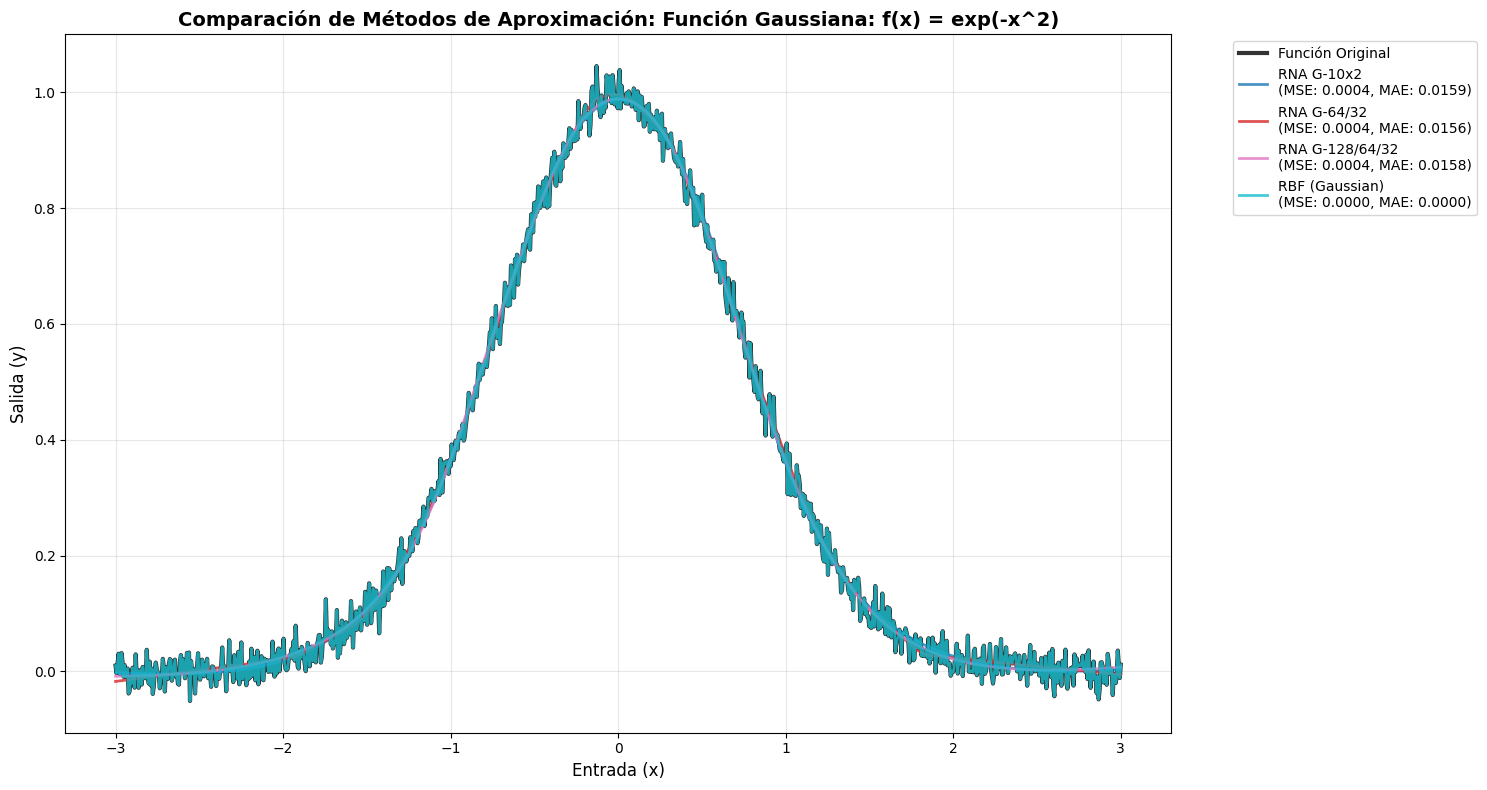


TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)
Método                    MSE             MAE             Ranking MSE 
--------------------------------------------------------------------------------
RBF (Gaussian)            0.000000        0.000000        1           
RNA G-64/32               0.000383        0.015602        2           
RNA G-128/64/32           0.000397        0.015757        3           
RNA G-10x2                0.000400        0.015863        4           


In [ ]:
    # ==========================================================================
    # 4. Requisito 2.3: Aproximar f(x) = exp(-x^2) con Múltiples Arquitecturas
    # ==========================================================================
    print("\n--- 2.3 Aproximación de Función Gaussiana (exp(-x^2)) ---")
    X_gauss, y_gauss, title_gauss = generate_gaussian_data(n_samples=1000)

    gauss_architectures = [
        ([10, 10], 'tanh', 200, 'RNA G-10x2'),
        ([64, 32], 'relu', 200, 'RNA G-64/32'),
        ([128, 64, 32], 'tanh', 300, 'RNA G-128/64/32')
    ]
    results_gauss = {}

    for config, activation, epochs, name in gauss_architectures:
        model = build_model(1, config, activation_fn=activation, lr=0.003)
        y_pred, mse, mae, history, _, _ = train_and_evaluate_nn(
            model, X_gauss, y_gauss, title_gauss, epochs=epochs, verbose=0
        )
        results_gauss[name] = (y_pred, mse, mae, history)

    # Añadir un método clásico (RBF es ideal para Gaussianas)
    y_pred_rbf, mse_rbf, mae_rbf, _ = approximate_with_rbf(X_gauss, y_gauss, function='gaussian')
    results_gauss['RBF (Gaussian)'] = (y_pred_rbf, mse_rbf, mae_rbf, None)

    # Visualización y tabla
    plot_comparison(X_gauss, y_gauss, results_gauss, title_gauss, show_errors=False)
    create_comparison_table(results_gauss)

In [ ]:
# ==============================================================================
# 7. EJECUCIÓN DE EXPERIMENTOS COMPARATIVOS (MODIFICADO: Se agrega Lineal)
# ==============================================================================

def run_comprehensive_comparison():
    """Ejecuta un análisis comparativo completo entre todos los métodos."""

    print("\n" + "="*100)
    print("ANÁLISIS COMPARATIVO COMPLETO DE MÉTODOS DE APROXIMACIÓN UNIVERSAL")
    print("="*100)

    # Se agrega la función Lineal (Requisito 1)
    experiments = [
        {
            'name': 'Función Lineal (Conversión)',
            'generator': generate_linear_data,
            # Arquitectura simple, ideal para regresión lineal
            'nn_config': {'layer_config': [10], 'activation_fn': 'relu', 'lr': 0.01},
            'epochs': 100
        },
        {
            'name': 'Función Coseno',
            'generator': generate_cosine_data,
            'nn_config': {'layer_config': [128, 64], 'activation_fn': 'tanh', 'lr': 0.003},
            'epochs': 400
        },
        {
            'name': 'Señal PWM',
            'generator': generate_pwm_data,
            'nn_config': {'layer_config': [256, 128, 64], 'activation_fn': 'relu', 'lr': 0.003},
            'epochs': 600
        },
        {
            'name': 'Función Compleja (Opcional)',
            'generator': generate_complex_function,
            'nn_config': {'layer_config': [256, 128, 64, 32], 'activation_fn': 'relu', 'lr': 0.002},
            'epochs': 800
        }
    ]

    for exp in experiments:
        print(f"\n\n{'#'*80}")
        print(f"EXPERIMENTO: {exp['name']}")
        print(f"{'#'*80}")

        X, y, title = exp['generator'](n_samples=1000)
        results = {}

        # 1. Red Neuronal
        model = build_model(input_dim=1, **exp['nn_config'])
        y_pred_nn, mse_nn, mae_nn, history, _, _ = train_and_evaluate_nn(
            model, X, y, title, epochs=exp['epochs'], verbose=1 # Verbose 1 para la ejecución principal
        )
        results['Red Neuronal'] = (y_pred_nn, mse_nn, mae_nn, history)

        plot_training_history(history, title)

        # 2. Métodos clásicos (Se incluye Polinomio para mostrar contraste)
        classical_methods = [
            lambda: approximate_with_polynomial(X, y, degree=12),
            lambda: approximate_with_rbf(X, y, function='multiquadric')
        ]

        for method in classical_methods:
            try:
                y_pred, mse, mae, method_name = method()
                results[method_name] = (y_pred, mse, mae, None)
            except Exception as e:
                print(f"Error en {method.__name__}: {e}")

        # Visualización comparativa
        plot_comparison(X, y, results, title, show_errors=True)

        # Tabla comparativa
        create_comparison_table(results)

In [ ]:
# ==============================================================================
# 8. ANÁLISIS DE ROBUSTEZ Y GENERALIZACIÓN (Mantenido)
# ==============================================================================

def analyze_robustness():
    """Analiza la robustez de los métodos con diferentes tamaños de dataset."""
    # (El cuerpo de esta función se mantiene sin cambios)
    print("\n\n" + "="*80)
    print("ANÁLISIS DE ROBUSTEZ CON DIFERENTES TAMAÑOS DE DATASET")
    print("="*80)

    sample_sizes = [50, 100, 500, 1000, 2000]
    methods = [
        ('Red Neuronal', lambda X, y: train_and_evaluate_nn(
            build_model(1, [64, 32], 'relu', lr=0.003), X, y, "Robustez", 200
        )),
        ('Polinomio (grado 8)', lambda X, y: approximate_with_polynomial(X, y, 8)),
        ('Splines Cúbicos', lambda X, y: approximate_with_splines(X, y)),
        ('k-NN (k=5)', lambda X, y: approximate_with_knn(X, y, 5)),
        ('Random Forest', lambda X, y: approximate_with_random_forest(X, y, 50, 10))
    ]

    results_robustness = {method_name: [] for method_name, _ in methods}

    for size in sample_sizes:
        X, y, _ = generate_complex_function(size)

        for method_name, method_func in methods:
            try:
                if method_name == 'Red Neuronal':
                    # train_and_evaluate_nn ahora retorna 6 valores, solo necesitamos el MSE
                    _, mse, _, _, _, _ = method_func(X, y)
                else:
                    _, mse, _, _ = method_func(X, y)
                results_robustness[method_name].append(mse)
            except Exception:
                results_robustness[method_name].append(np.nan)

    plt.figure(figsize=(12, 8))
    for method_name, mse_values in results_robustness.items():
        valid_sizes = [size for size, mse in zip(sample_sizes, mse_values) if not np.isnan(mse)]
        valid_mse = [mse for mse in mse_values if not np.isnan(mse)]
        plt.plot(valid_sizes, valid_mse, 'o-', label=method_name, linewidth=2, markersize=8)

    plt.xlabel('Tamaño del Dataset')
    plt.ylabel('MSE')
    plt.title('Análisis de Robustez: MSE vs Tamaño del Dataset')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


ANÁLISIS COMPARATIVO COMPLETO DE MÉTODOS DE APROXIMACIÓN UNIVERSAL


################################################################################
EXPERIMENTO: Función Lineal (Conversión)
################################################################################

--- Generando 1000 muestras para función lineal ---
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.2451 - mae: 1.4624 - val_loss: 1.8337 - val_mae: 1.1228 - learning_rate: 0.0100
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8596 - mae: 1.1396 - val_loss: 1.2217 - val_mae: 0.9392 - learning_rate: 0.0100
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2069 - mae: 0.9383 - val_loss: 0.8753 - val_mae: 0.7969 - learning_rate: 0.0100
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8324 - mae: 0.7829 - val_loss: 0.5999 - val_mae: 0.6577 - learning_rate: 0.0100
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5417 - mae: 0.6279 - val_loss: 0.3344 - val_mae: 0.4865

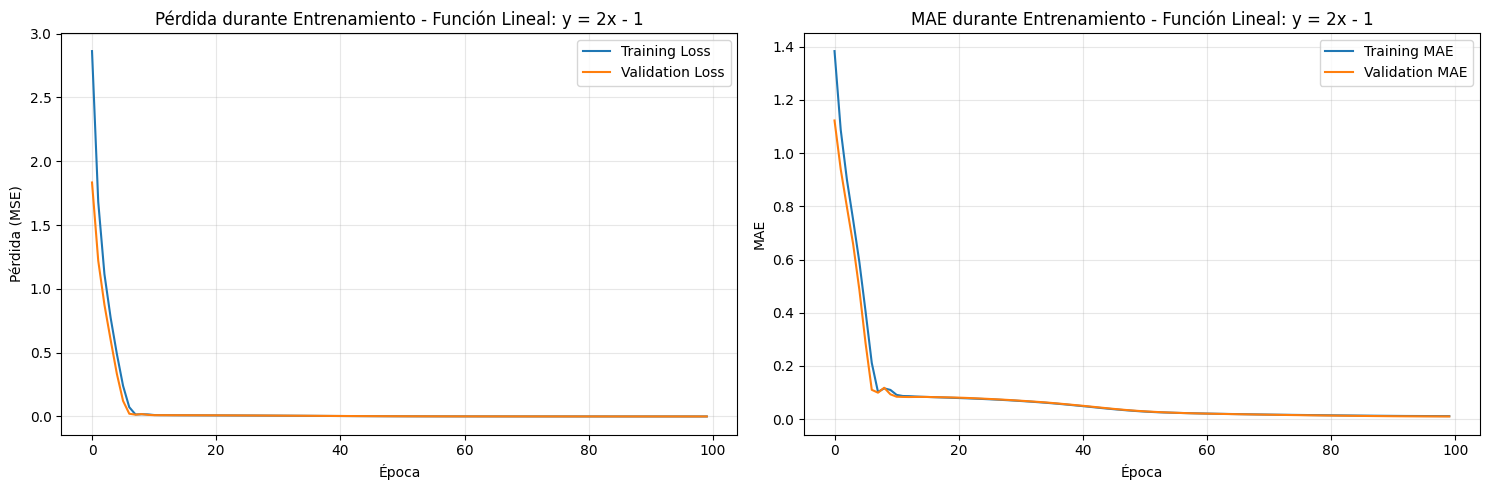

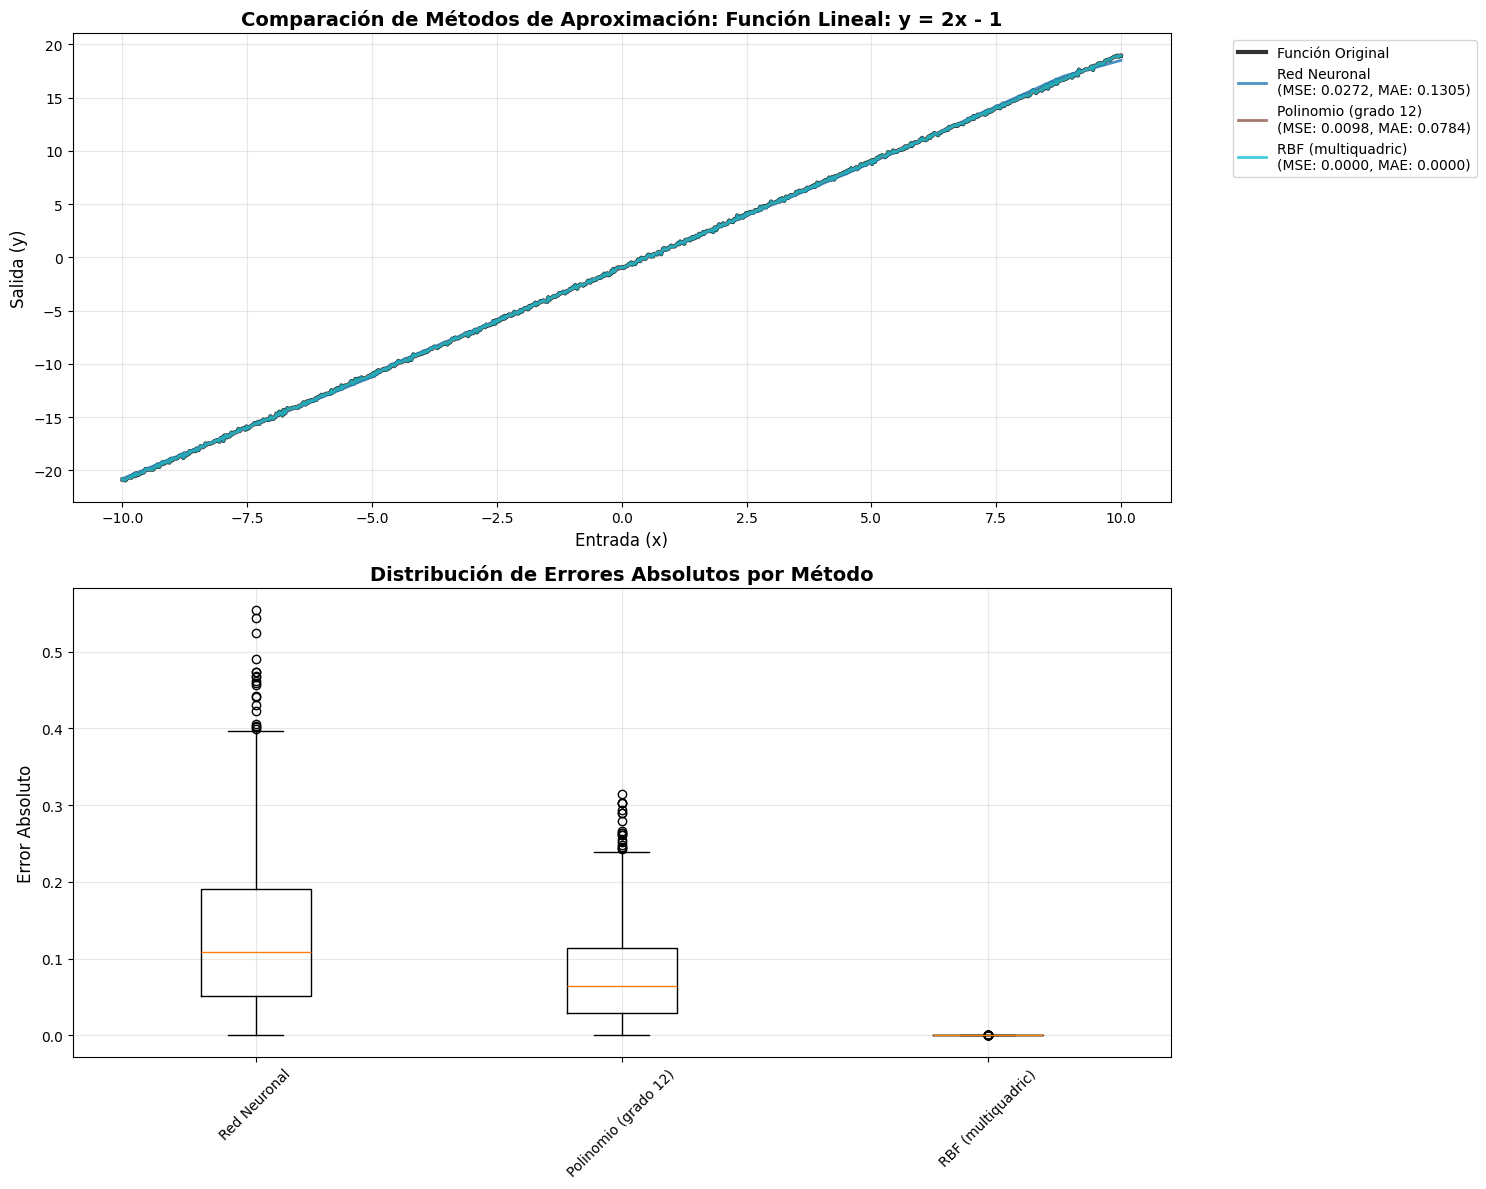


TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)
Método                    MSE             MAE             Ranking MSE 
--------------------------------------------------------------------------------
RBF (multiquadric)        0.000000        0.000000        1           
Polinomio (grado 12)      0.009827        0.078392        2           
Red Neuronal              0.027168        0.130518        3           


################################################################################
EXPERIMENTO: Función Coseno
################################################################################

--- Generando 1000 muestras para función coseno (Personalizada) ---
Epoch 1/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.0111 - mae: 0.8844 - val_loss: 1.0668 - val_mae: 0.9382 - learning_rate: 0.0030
Epoch 2/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9988 - mae: 0.8901 - val_loss: 1.0620 - val_mae: 0.9412 - learning_rate: 0.0030
Epoch 3/400
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11

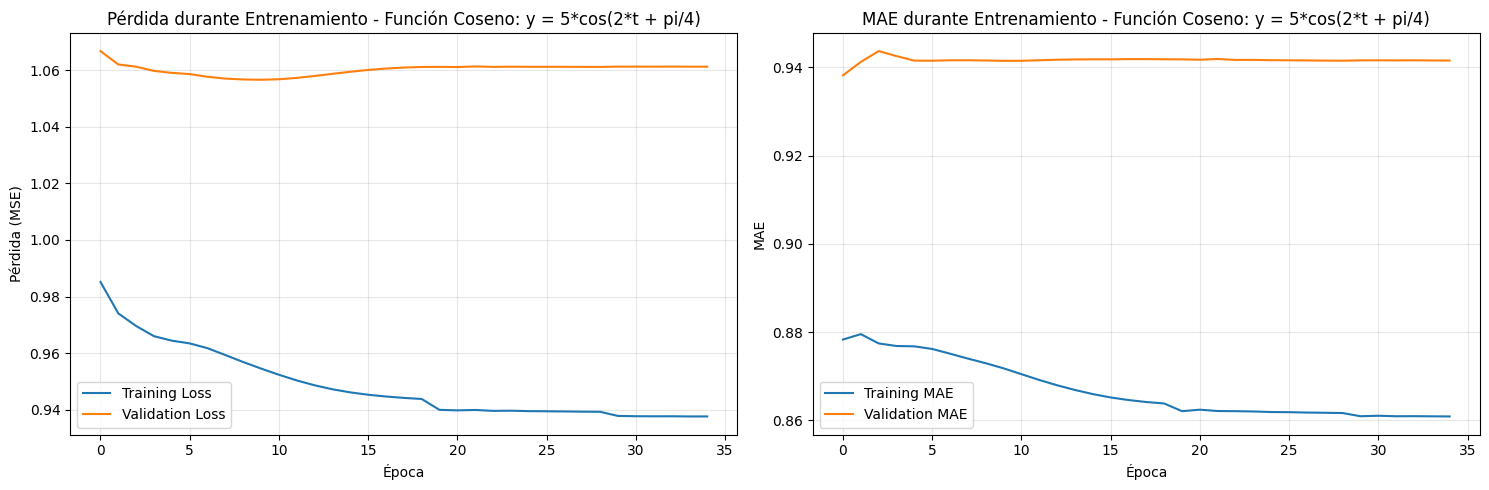

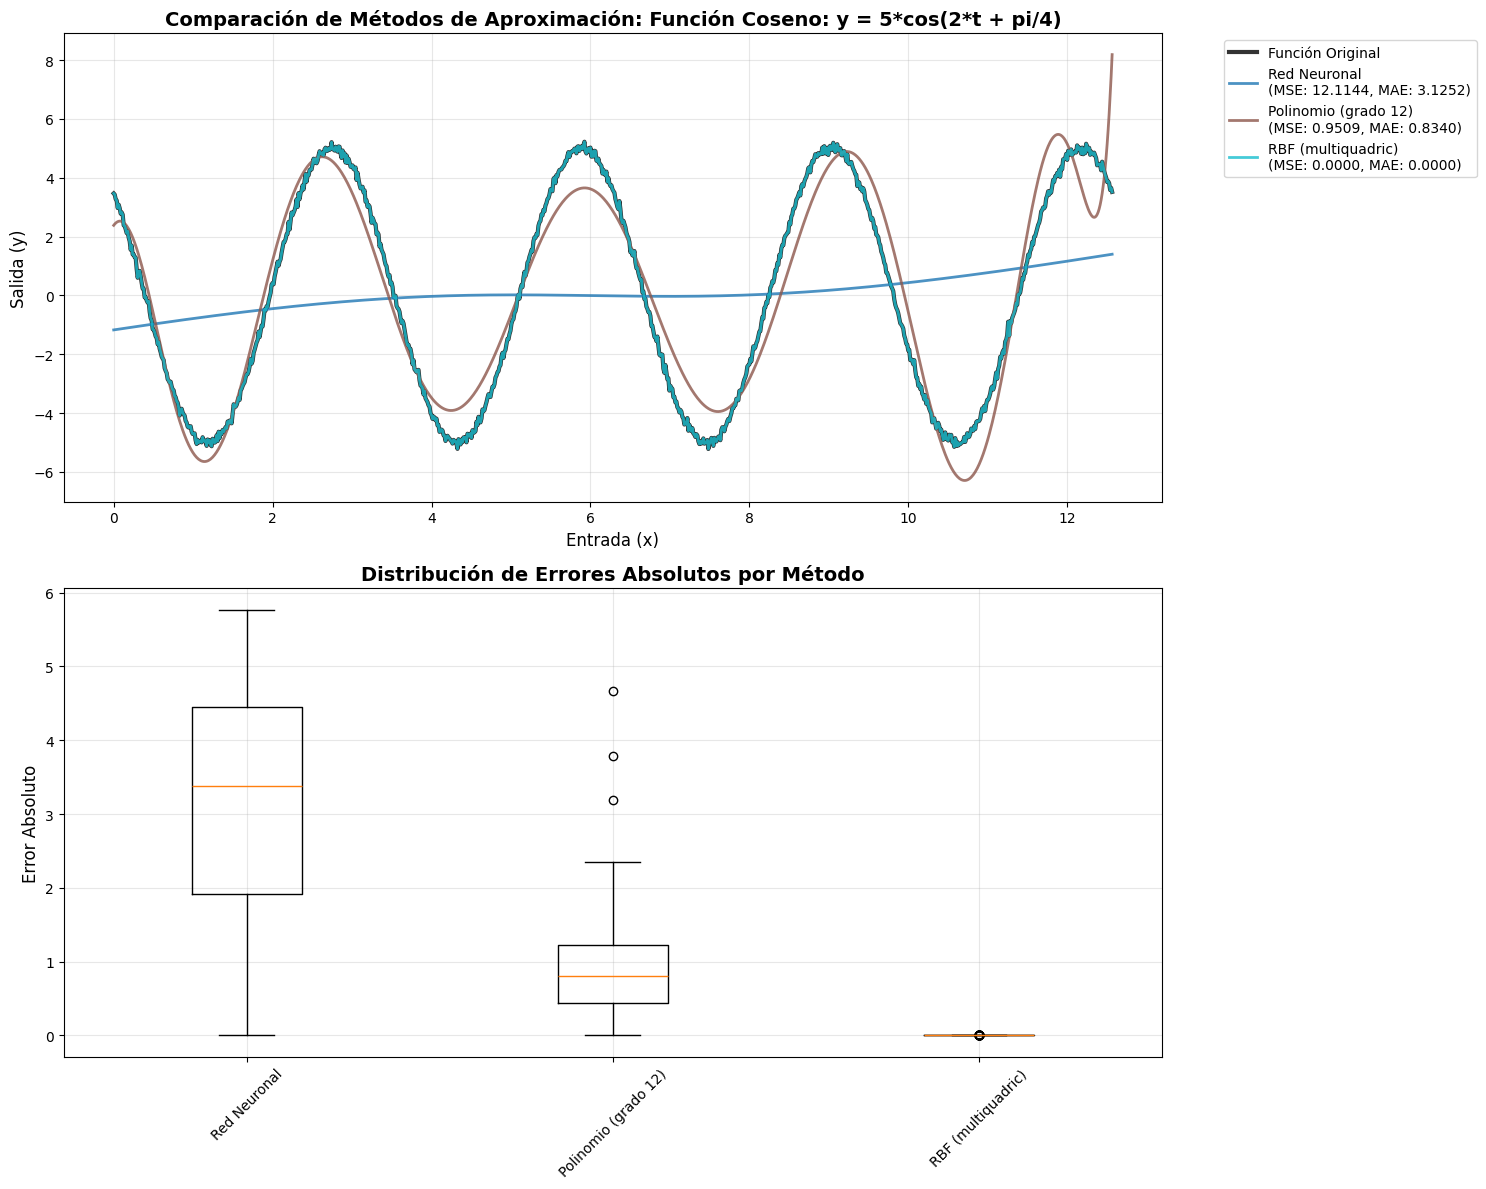


TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)
Método                    MSE             MAE             Ranking MSE 
--------------------------------------------------------------------------------
RBF (multiquadric)        0.000000        0.000000        1           
Polinomio (grado 12)      0.950935        0.834013        2           
Red Neuronal              12.114413       3.125226        3           


################################################################################
EXPERIMENTO: Señal PWM
################################################################################

--- Generando 1000 muestras para señal PWM ---
Epoch 1/600
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 1.0517 - mae: 0.9536 - val_loss: 0.9270 - val_mae: 0.8574 - learning_rate: 0.0030
Epoch 2/600
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0600 - mae: 0.9249 - val_loss: 0.9183 - val_mae: 0.8848 - learning_rate: 0.0030
Epoch 3/600
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0379 - m

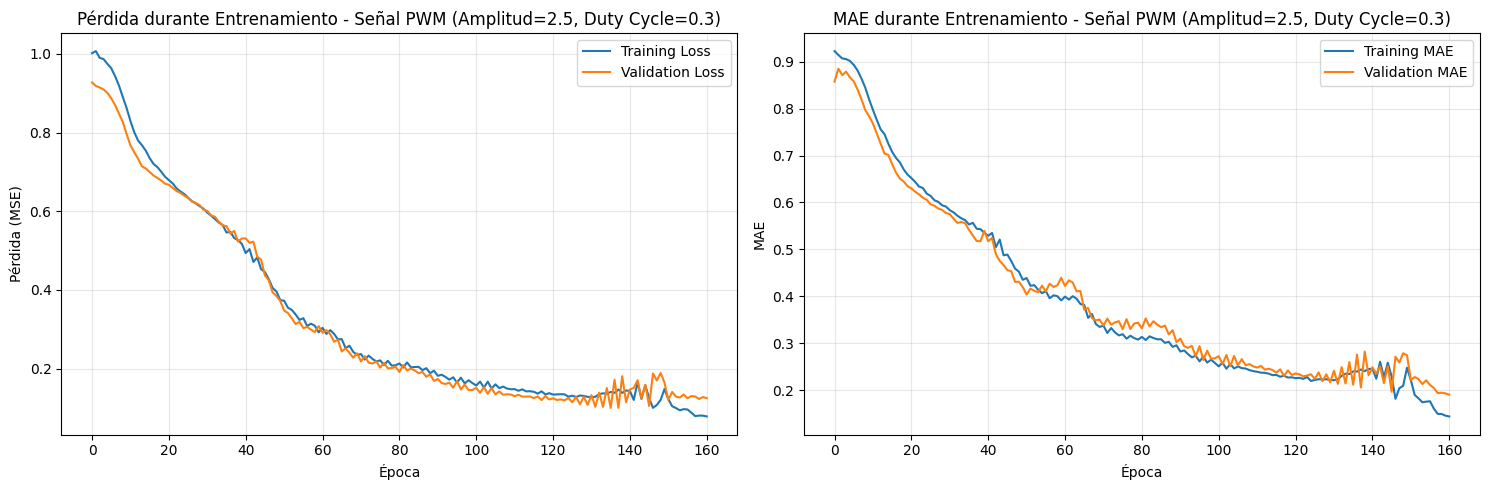

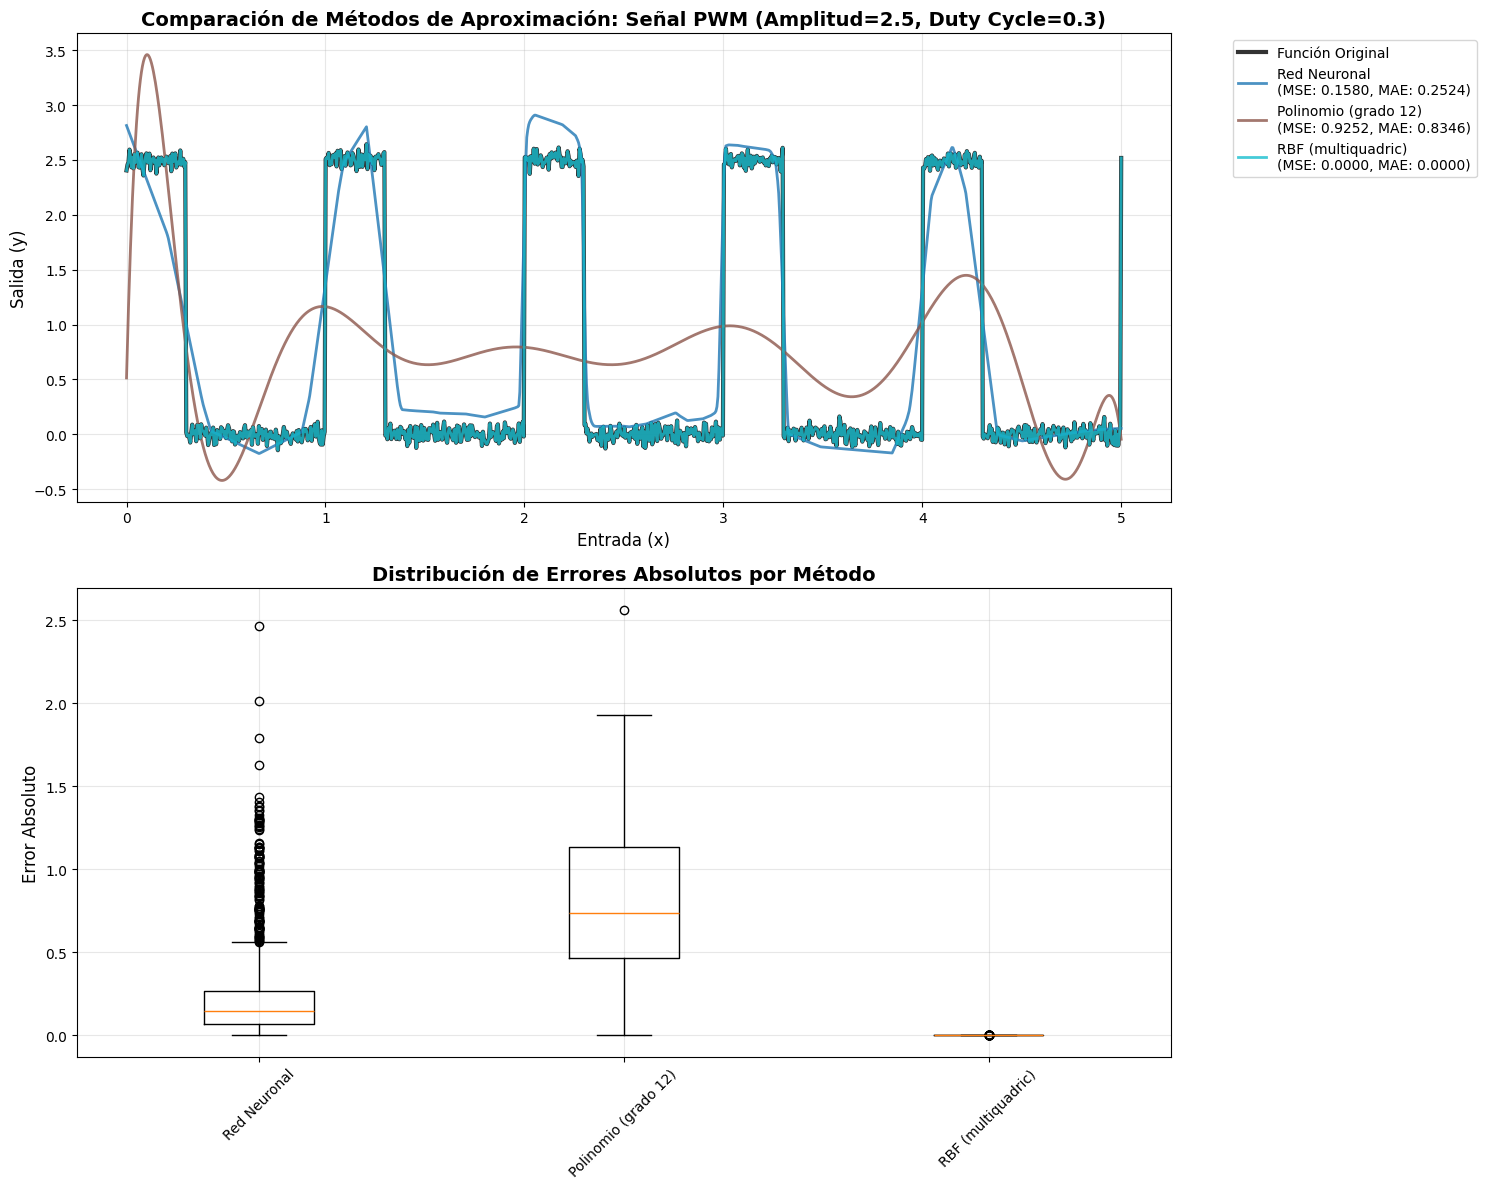


TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)
Método                    MSE             MAE             Ranking MSE 
--------------------------------------------------------------------------------
RBF (multiquadric)        0.000000        0.000000        1           
Red Neuronal              0.157992        0.252376        2           
Polinomio (grado 12)      0.925156        0.834588        3           


################################################################################
EXPERIMENTO: Función Compleja (Opcional)
################################################################################

--- Generando 1000 muestras para función compleja (No requerida) ---
Epoch 1/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.9351 - mae: 0.5950 - val_loss: 0.9811 - val_mae: 0.6012 - learning_rate: 0.0020
Epoch 2/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9252 - mae: 0.5844 - val_loss: 0.9561 - val_mae: 0.5835 - learning_rate: 0.0020
Epoch 3/800
9/9 ━━━━━━━━━━━━

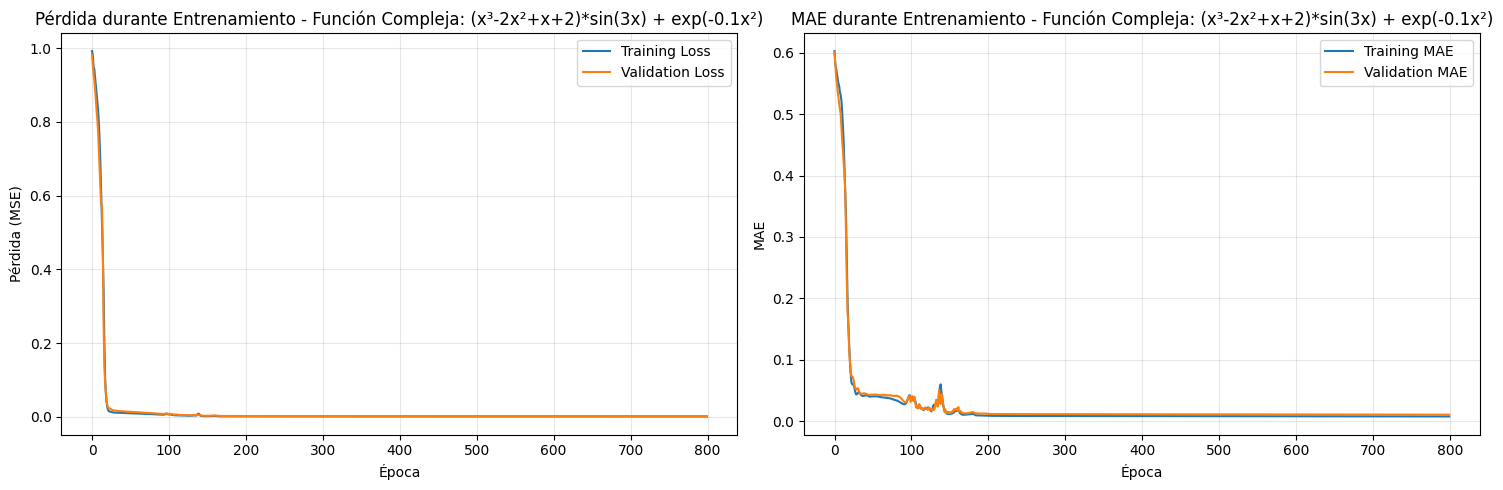

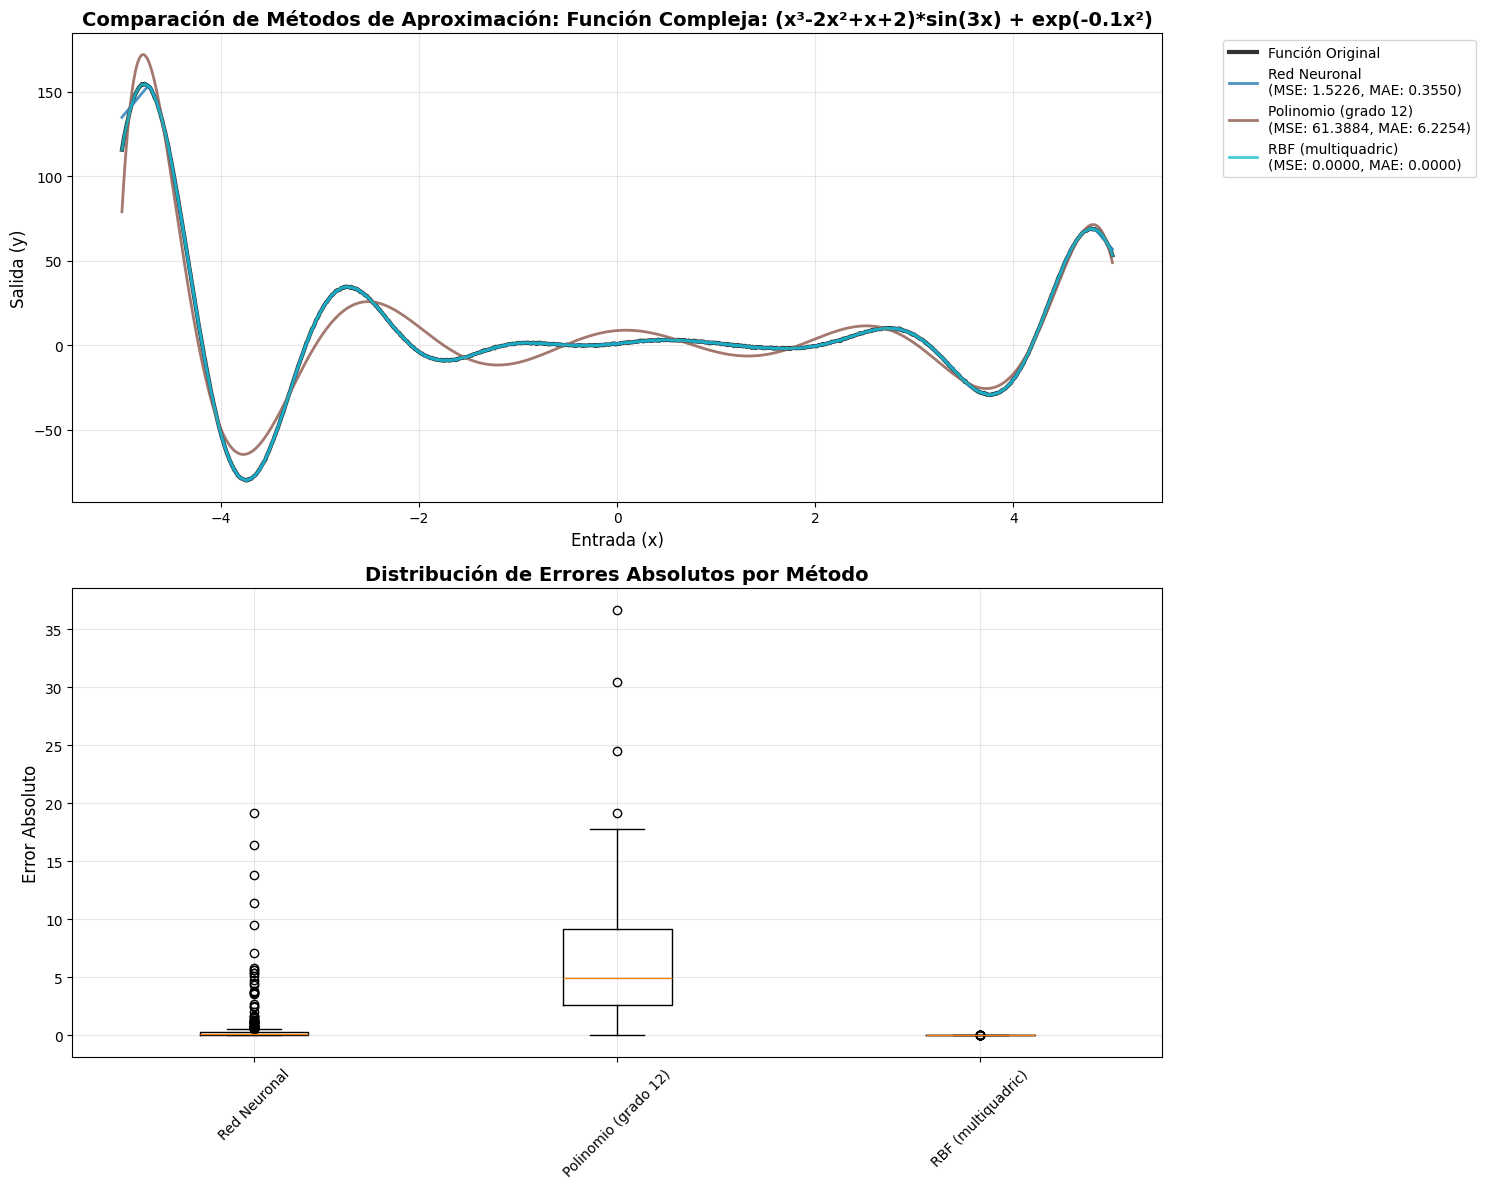


TABLA COMPARATIVA DE RESULTADOS (Ordenado por MSE)
Método                    MSE             MAE             Ranking MSE 
--------------------------------------------------------------------------------
RBF (multiquadric)        0.000000        0.000000        1           
Red Neuronal              1.522598        0.354959        2           
Polinomio (grado 12)      61.388373       6.225442        3           


ANÁLISIS DE IMPLICACIONES DE LA ARQUITECTURA DE LA RNA

--- Generando 1000 muestras para función cos(x) ---

--- 2.1 Impacto del Número de Neuronas (cos(x)) ---

Tabla de Comparación (Número de Neuronas):
| Arquitectura   | Activación   |   MSE_Test |
|:---------------|:-------------|-----------:|
| [50, 50]       | relu         |   0.006170 |
| [100]          | relu         |   0.010026 |
| [4]            | relu         |   0.010578 |

Mejor arquitectura seleccionada para el análisis de activación: [50, 50]


ANÁLISIS DE ROBUSTEZ CON DIFERENTES TAMAÑOS DE DATASET

--- Gener


--- Generando 500 muestras para función compleja (No requerida) ---

--- Generando 1000 muestras para función compleja (No requerida) ---

--- Generando 2000 muestras para función compleja (No requerida) ---


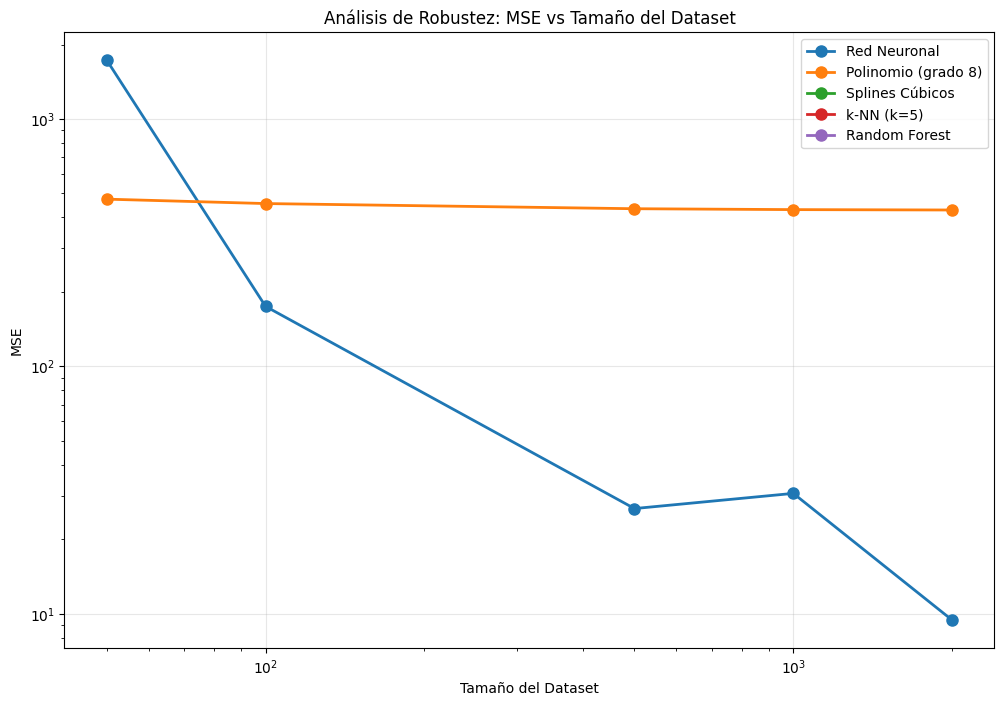


PRÁCTICA COMPLETADA EXITOSAMENTE (MÍNIMO INDISPENSABLE CUBIERTO)


In [ ]:
# ==============================================================================
# 9. EJECUCIÓN PRINCIPAL (MODIFICADO: Se llama a la nueva función de análisis)
# ==============================================================================

if __name__ == '__main__':
    # Ejecutar análisis comparativo completo (Incluye la función Lineal)
    run_comprehensive_comparison()

    # Ejecutar análisis de implicaciones de la arquitectura (Requisito 2.1, 2.2, 2.3)
    analyze_architecture_implications()

    # Ejecutar análisis de robustez
    analyze_robustness()

    print("\n" + "="*100)
    print("PRÁCTICA COMPLETADA EXITOSAMENTE (MÍNIMO INDISPENSABLE CUBIERTO)")
    print("="*100)